In [2]:
using FunctionalCollections
using Iterators
using Pipe
using Compat

macro printval(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr," = ", $ee)))
end

macro pz(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr,"\t\t",typeof($ee), "\t", size($ee))))
end

push!(LOAD_PATH, ".")
push!(LOAD_PATH, "../util/")
using DataStructures
using DataStructuresExtended
using JLD
using DataFrames

In [3]:
function groupby_value(fn::Function, xs)
    key_type = typeof(fn(first(xs)))
    group_type = Vector{typeof(first(xs))}
    groups = Dict{key_type, group_type}()
    
    for x in xs
        key = fn(x)
        group = get!(()->group_type(), groups, key)
        push!(group, x)
    end
    groups
end
function round_tbl(data::DataFrame, places=2)
    ret = copy(data)
    for (ii,column) in enumerate(ret.columns)
        if typeof(column[1])<:Number #hack
            ret.columns[ii] = round(column, places)
        end
    end
    ret
end


round_tbl (generic function with 2 methods)

In [4]:
function flatten_blocked_records{T<:Number, V}(records::Dict{T,V})  
    rec_types = @pipe records |> values |> map(typeof,_) |> union
    rec_type = length(rec_types)==1 ? rec_types[1] : V
    ret = rec_type() #Construct it, it is some form of vector, or we will error soon
    sizehint!(ret) = sum([length(r) for r in values(records)])
    
    sorted_keys = @pipe records |> keys |> collect |> sort
    for key in sorted_keys
        push!(ret, records[key]...)
    end
    ret
end

function flatten_raw_blocked_records{T,V}(records::Dict{T,V})  
    key_types = @pipe records |> keys|> map(parse,_) |> map(typeof,_) |> union
    @assert length(key_types)==1
    key_type =  key_types[1]
    
    rec_types = @pipe records |> values |> map(typeof,_) |> union
    rec_type = length(rec_types)==1 ? rec_types[1] : V
    flatten_blocked_records(Dict(Pair{key_type, rec_type}[parse(k)=>v for (k,v) in records]))
end

flatten_raw_blocked_records (generic function with 1 method)

In [5]:
OUTPUT_DIR = "../../documents_prepared/Journal\ Papers/SumResynthesis/data/"

"../../documents_prepared/Journal Papers/SumResynthesis/data/"

In [ ]:
######Unordered/BOW

In [ ]:
function jaccard_index(aa::DataStructures.Accumulator,bb::DataStructures.Accumulator)
    sum(intersect(aa,bb))/sum(union(aa,bb))
end

function jaccard_index(aa,bb)
    length(intersect(aa,bb))/length(union(aa,bb))
end

In [ ]:
function precision(actual::DataStructures.Accumulator,reference::DataStructures.Accumulator)
    sum(intersect(actual,reference))/sum(actual)
end
function recall(actual::DataStructures.Accumulator,reference::DataStructures.Accumulator)
    sum(intersect(actual,reference))/sum(reference)
end

function f1_score(actual::DataStructures.Accumulator,reference::DataStructures.Accumulator)
    prec = precision(actual,reference)
    rec = recall(actual,reference)
    2*prec*rec/(prec+rec)
end

In [ ]:

#books_glove300cityblock_raw = load("results/bags/books_corpus_0.001_of_test_glove300_cityblock.jld","4")
books_0_01_glove300_raw = flatten_raw_blocked_records(load("results/bags/books_corpus_0.01_of_test.jld"))
#books_001o_glove300_raw = flatten_raw_blocked_records(load("results/bags/books_corpus_0.01_of_test_glove300.jld"))
brown_glove300_raw = load("results/bags/brown_glove300_res.jld", "res")
brown_glove200_raw = load("results/bags/brown_glove200_res.jld", "res")
brown_glove100_raw = load("results/bags/brown_glove100_res.jld", "res")
brown_glove50_raw = load("results/bags/brown_glove50_res.jld", "res")

In [ ]:
@assert all([rset[1] for rset in brown_glove50_raw] .== [rset[1] for rset in brown_glove300_raw])
@assert all([rset[1] for rset in brown_glove50_raw] .== [rset[1] for rset in brown_glove200_raw])
@assert all([rset[1] for rset in brown_glove50_raw] .== [rset[1] for rset in brown_glove100_raw])

In [ ]:
Mean

In [ ]:
bag_res = DataFrame()
bag_res[:ground] = [counter(rset[1]) for rset in brown_glove50_raw]# books_0_01_glove300_raw]
bag_res[:ground_len] = Int[sum(ss) for ss in bag_res[:ground]]
exp_names = ASCIIString[]
for raw_name in ["brown_glove50_raw","brown_glove100_raw", "brown_glove200_raw", "brown_glove300_raw"]#
#for raw_name in ["books_0_01_glove300_raw"]
    colname = join(split(raw_name,"_")[1:end-1],"_")
    push!(exp_names, colname)
    raw = eval(raw_name|>Symbol)
    bag_res[colname*"_actual"|> Symbol] = [counter(rset[2]) for rset in raw]
    #bag_res[colname*"_distance"|> Symbol] = Float64[-1*rset[3] for rset in raw]
end

#bag_res

In [ ]:
for exp_name in exp_names
    actual = bag_res[exp_name*"_actual" |> symbol]
    bag_res[exp_name*"_perfect" |> symbol] = actual.==bag_res[:ground]
    bag_res[exp_name*"_jaccard" |> symbol] = map(jaccard_index, actual, bag_res[:ground])
    bag_res[exp_name*"_precision" |> symbol] = map(precision, actual, bag_res[:ground])
    bag_res[exp_name*"_recall" |> symbol] = map(recall, actual, bag_res[:ground])
    bag_res[exp_name*"_f1" |> symbol] = map(f1_score, actual, bag_res[:ground])
end

In [ ]:
keep_cols = @pipe (bag_res.colindex |> keys |> map(string,_)
                    |>filter(col -> contains(col,"jaccard") 
                                ||  contains(col,"perfect") 
                                ||  contains(col,"recall")
                                ||  contains(col,"_precision")
                                ||  contains(col,"f1" ),_)
                    |> map(Symbol,_))
len_scores = aggregate(bag_res[[:ground_len, keep_cols...]], :ground_len, mean)
sort!(len_scores)
writetable(OUTPUT_DIR*"selection_len_scores.csv", len_scores)
len_scores |> round_tbl

In [ ]:
writetable(OUTPUT_DIR*"selection_len_scores_brown.csv", len_scores)

In [ ]:
cum_len_scores = DataFrame()
cum_len_scores[:max_ground_len] = bag_res[:ground_len] |> unique |> sort!
for col in keep_cols
    cum_len_scores[col] = Float64[ begin
        shortish_sents = bag_res[:ground_len] .<= max_len;
        shortish_bag_res = bag_res[shortish_sents, col]
        shortish_bag_res[isfinite(shortish_bag_res)] |> mean
         end for max_len in cum_len_scores[:max_ground_len]]
end

writetable(OUTPUT_DIR*"selection_cum_len_scores_books.csv", cum_len_scores)
cum_len_scores |> round_tbl


In [ ]:
cum_len_scores[end,:] 

In [ ]:
function longform(df::DataFrame, index::Symbol, cols::Vector{Symbol}, new_name::Symbol)
    function subdf(col::Symbol)
        df_sub = df[[index, col]]
        rename!(df_sub, col, new_name)
        df_sub[:label] = col
        df_sub
    end
    vcat([subdf(col) for col in cols]...)
end

In [ ]:
using Gadfly

In [ ]:
p=Gadfly.plot(longform(cum_len_scores, :max_ground_len, jaccard_cols, :mean_jaccard_index),
    x="max_ground_len", y="mean_jaccard_index",
    color="label",
    Coord.Cartesian(ymin=0),
    Geom.point
)
#draw(PNG("brown_cumulative_length_score.png", 24cm, 6cm), p)

In [ ]:

p=Gadfly.plot(longform(len_scores, :ground_len, [string(col)*"_mean"|> Symbol for col in jaccard_cols], :mean_jaccard_index),
    x="ground_len", y="mean_jaccard_index",
    color="label",
    Geom.point
)
#draw(PNG("brown_length_score.png", 24cm, 6cm), p)

In [ ]:
bag_res[:ground_len] |> describe 
p=Gadfly.plot(bag_res, x="ground_len",  Geom.histogram)
#draw(PNG("brown_length_dist.png", 24cm, 6cm), p)

In [ ]:
##############################################
# ORDERED
########################################

In [6]:
using PyCall
@pyimport nltk
@pyimport nltk.align.bleu_score as nltk_bleu

function bleu_score(candidate, reference)
    reference = reference |> collect
    candidate = candidate |> collect
    
    if reference==candidate #Perfect Match
        1.0
    else
        weights = [1,1,1,1]/4
        nltk_bleu.bleu(candidate,Any[reference], weights)
    end
end

/usr/local/lib/python2.7/dist-packages/nltk/app/__init__.py:29: UserWarning: nltk.app package not loaded (please install Tkinter library).
  warnings.warn("nltk.app package not loaded "
/usr/local/lib/python2.7/dist-packages/nltk/draw/__init__.py:15: UserWarning: nltk.draw package not loaded (please install Tkinter library).
  warnings.warn("nltk.draw package not loaded "


bleu_score (generic function with 1 method)

In [7]:
bleu_score(["the","comedy","of","manners","of","this","first","a","basis","is","performed","in","1892","."],
           ["this","is","the" ,"basis","of","a" ,"comedy" ,"of","manners","first","performed","in","1892", "."]
)

0.30576902884505114

In [8]:
immutable OrderRecord{T}
    reference::Vector{T}
    actual::Vector{T}
    prob::Float64
    time::Float64
    status::Symbol
end

In [10]:
function load_ordering_results(path, keys)
    blocked_records = Dict{Int,Any}([key=>load(path,string(key)) for key in keys])
    @pipe blocked_records |> flatten_blocked_records |> map(r->OrderRecord(r...),_)
end

#books_0_001 = load_ordering_results("results/ordered/books_corpus_0.001_of_test_glove300.jld", 1:100)
#books_0_001_oracle = load_ordering_results("results/ordered/books_corpus_0.001_of_test_oracle.jld", 1:100)

load_ordering_results (generic function with 1 method)

In [24]:
books_0_01 = load_ordering_results("results/ordered/books_corpus_0.01_of_test.jld", 1:1000)
books_0_01_oracle = load_ordering_results("results/ordered/books_corpus_0.01_of_test_oracle.jld", 1:1000)

66464-element Array{OrderRecord{Symbol},1}:
 OrderRecord{Symbol}([:okay,symbol(","),:i,:said,symbol(","),:this,:is,:going,:to,:be,:some,:fun,:revenge,:.],[:i,:it,:be,:.,symbol(","),:going,:revenge,:some,symbol(","),:brainchild,symbol("74.9"),:go,:very,:also,symbol("'ll"),:adding],NaN,11.252397509,:Infeasible)                                                                                                                  
 OrderRecord{Symbol}([:this,:is,:just,:great,symbol(","),:seth,:shouted,:.],[:seth,:shouted,symbol(","),:this,:is,:just,:great,:.],1.2525495659807909e-15,2.474224255,:Optimal)                                                                                                                                                                                                             
 OrderRecord{Symbol}([:start,:in,:the,:beginning,:and,:do,symbol("n't"),:hold,:anything,:back,:.],[:do,symbol("n't"),:hold,:anything,:back,:and,:start,:in,:the,:beginning,:.],4.550069306365155e-

In [71]:
attempted_only{T<:OrderRecord}(recs::Vector{T}) = filter(r->r.status!=:NotAttempted, recs)
feasible_only{T<:OrderRecord}(recs::Vector{T}) = filter(r->r.status!=:Infeasible, recs)


feasible_only (generic function with 1 method)

In [72]:
function exact_match(rec::OrderRecord)
    rec.reference == rec.actual
end
function bleu_score(rec::OrderRecord)
    bleu_score( rec.actual, rec.reference)
end

bleu_score (generic function with 2 methods)

In [73]:
eval_methods = [
    (symbol("Time Taken (s)"), data -> map(r->r.time , data|> attempted_only)),
    (symbol("BLEU Score"), data ->     map(bleu_score,  data|> attempted_only)),
    (symbol("Portion Perfect"), data ->  map(exact_match, data|> attempted_only)),
    (symbol("Portion Feasible"), data ->     map(r->r.status==:Optimal, data|> attempted_only)),
    (symbol("Portion Perfect (Feasible Only)"), data ->  map(exact_match, data|> attempted_only |>feasible_only)),
    (symbol("BLEU Score (Feasible Only)"), data ->     map(bleu_score,  data|> attempted_only |>feasible_only) ),
]

6-element Array{Tuple{Symbol,Function},1}:
 (symbol("Time Taken (s)"),(anonymous function))                 
 (symbol("BLEU Score"),(anonymous function))                     
 (symbol("Portion Perfect"),(anonymous function))                
 (symbol("Portion Feasible"),(anonymous function))               
 (symbol("Portion Perfect (Feasible Only)"),(anonymous function))
 (symbol("BLEU Score (Feasible Only)"),(anonymous function))     

In [107]:
function get_ordering_res(;datas...)
    ordering_res = DataFrame(Input=map(kw->kw[1],datas))
    for (method, fn) in eval_methods
        println(method)
        ordering_res[method]=[mean(fn(data)) for (model, data) in datas]
    end
    ordering_res
end

ordering_res = get_ordering_res(Generated=books_0_01, Oracle=books_0_01_oracle)

writetable(OUTPUT_DIR*"ordering_scores.csv", ordering_res)
round_tbl(ordering_res)

Time Taken (s)
BLEU Score
Portion Perfect
Portion Feasible
Portion Perfect (Feasible Only)
BLEU Score (Feasible Only)


,Input,Time Taken (s),BLEU Score,Portion Perfect,Portion Feasible,Portion Perfect (Feasible Only),BLEU Score (Feasible Only)
1,Generated,7.04,0.75,0.62,0.94,0.66,0.79
2,Oracle,6.7,0.81,0.67,1.0,0.67,0.81


In [117]:
function mean_by_length{T<:OrderRecord}(rater::Function, data::Vector{T}, assessed_lengths)
    groups = groupby_value(r->length(r.reference), data) #r.reference is the ground truth sentence
    [ mean(rater(groups[len])) for len in assessed_lengths]
end
function get_instance_counts(data)
    groups = groupby_value(r->length(r.reference), data) 
    [length(groups[sent_len]) for sent_len in sort(collect(keys(groups)))]
end

function get_ordering_length_res(data)
    ordering_length_res = DataFrame(
        ground_length=1:maximum([length(r.reference) for r in data |> attempted_only]),
        Instances = get_instance_counts(data|> attempted_only))
    for (method, fn) in eval_methods
        println(method)
        ordering_length_res[method]=mean_by_length(fn,data, ordering_length_res[:ground_length])
    end
    return ordering_length_res
    #Time_taken = mean_by_length(r->r.time , data|> attempted_only),
    #BLEU_Score    =  mean_by_length(bleu_score,  data|> attempted_only),
    #Exact_Matches =  mean_by_length(exact_match, data|> attempted_only),    
    #Feasible      =  mean_by_length(r->r.status==:Optimal, data|> attempted_only),
    #Exact_Matches_Feasible_only =  mean_by_length(exact_match, data|> attempted_only |>feasible_only),
    #BLEU_Score_feasible_only    =  mean_by_length(bleu_score,  data|> attempted_only |>feasible_only) 
end
ordering_length_res = get_ordering_length_res(books_0_01)
writetable(OUTPUT_DIR*"ordering_length_scores.csv", ordering_length_res)
round_tbl(ordering_length_res)

Time Taken (s)
BLEU Score
Portion Perfect
Portion Feasible
Portion Perfect (Feasible Only)


,ground_length,Instances,Time Taken (s),BLEU Score,Portion Perfect,Portion Feasible,Portion Perfect (Feasible Only),BLEU Score (Feasible Only)
1,1,57.0,0.04,1.0,1.0,1.0,1.0,1.0
2,2,1165.0,0.06,1.0,1.0,1.0,1.0,1.0
3,3,3043.0,0.13,0.97,0.97,0.98,0.98,0.98
4,4,3295.0,0.24,0.95,0.95,0.99,0.96,0.96
5,5,4105.0,0.39,0.91,0.91,0.99,0.92,0.92
6,6,4299.0,0.64,0.87,0.85,0.99,0.86,0.87
7,7,4606.0,0.91,0.83,0.8,0.99,0.81,0.84
8,8,4279.0,1.32,0.8,0.74,0.98,0.75,0.82
9,9,4080.0,1.81,0.77,0.66,0.97,0.68,0.79
10,10,3768.0,2.58,0.73,0.59,0.97,0.61,0.76


BLEU Score (Feasible Only)


In [118]:
ordering_length_res_oracle = get_ordering_length_res(books_0_01_oracle)
writetable(OUTPUT_DIR*"ordering_length_scores_oracle.csv", ordering_length_res)
round_tbl(ordering_length_res_oracle)

Time Taken (s)
BLEU Score
Portion Perfect
Portion Feasible
Portion Perfect (Feasible Only)


,ground_length,Instances,Time Taken (s),BLEU Score,Portion Perfect,Portion Feasible,Portion Perfect (Feasible Only),BLEU Score (Feasible Only)
1,1,57.0,0.02,1.0,1.0,1.0,1.0,1.0
2,2,1165.0,0.07,1.0,1.0,1.0,1.0,1.0
3,3,3043.0,0.12,0.97,0.97,0.98,0.98,0.98
4,4,3295.0,0.23,0.95,0.95,0.99,0.96,0.96
5,5,4105.0,0.38,0.92,0.92,0.99,0.93,0.93
6,6,4299.0,0.59,0.89,0.87,1.0,0.88,0.89
7,7,4606.0,0.89,0.86,0.83,1.0,0.83,0.86
8,8,4279.0,1.3,0.84,0.78,1.0,0.78,0.84
9,9,4080.0,1.77,0.81,0.71,1.0,0.71,0.81
10,10,3768.0,2.49,0.78,0.64,1.0,0.64,0.79


BLEU Score (Feasible Only)


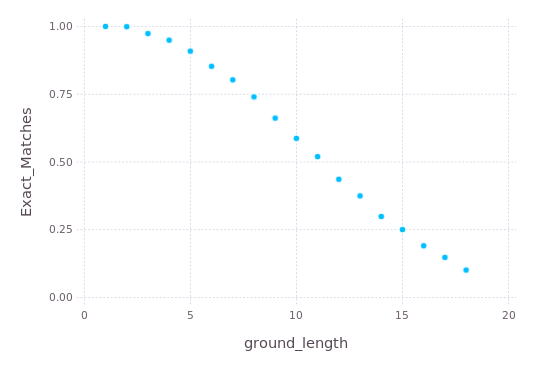

In [27]:
Gadfly.plot(ordering_length_res, x=:ground_length, y=:Exact_Matches)

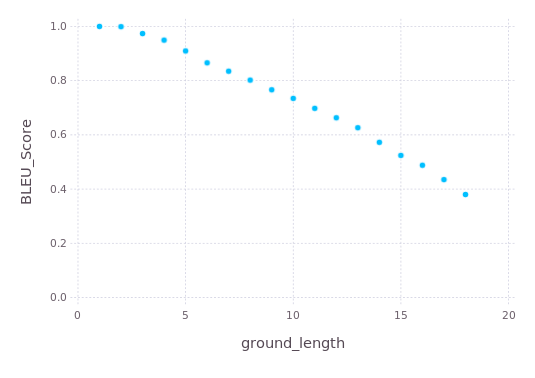

In [28]:
Gadfly.plot(ordering_length_res, x=:ground_length, y=:BLEU_Score)

In [21]:
using Gadfly

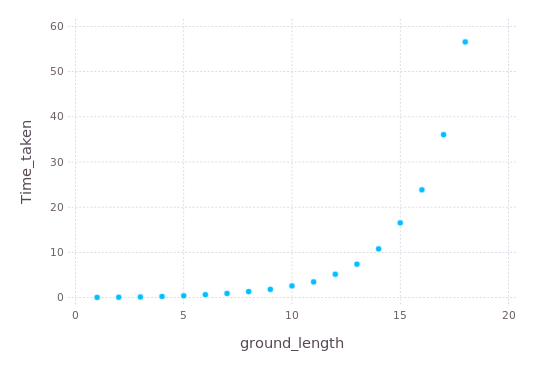

In [29]:
p=Gadfly.plot(ordering_length_res, x=:ground_length, y=:Time_taken)
#draw(PNG("ordering_time_taken_vs_length.png", 10cm, 6cm), p)

In [32]:
function cum_means(indexed_data::DataFrame, index_col=:ground_length, count_col=:Instances)
    @assert issorted(indexed_data[index_col])
    cum_data=DataFrame()
    cum_data[Symbol("max_"*string(index_col))] = indexed_data[index_col]
    cum_data[count_col] = cumsum(indexed_data[count_col])
    keep_cols = @pipe indexed_data.colindex |> keys |> collect |> filter(col->col∉[index_col, count_col], _) |> collect
    for col in keep_cols
        total_count = 0
        total_score = 0
        prev_index = 0 
        function cum(ii)
            @assert ii>prev_index
            score = indexed_data[ii,col]
            count = indexed_data[ii,count_col]
            total_score = (total_score*total_count+score*count)/(total_count+count)
            total_count+=count
            prev_index = ii
            return total_score
        end
        cum_data[col]= map(cum, 1:length(indexed_data[col]))
    end
    cum_data
end
    

cum_means (generic function with 3 methods)

In [33]:
cum_means(ordering_length_res)

,max_ground_length,Instances,Time_taken,BLEU_Score,Exact_Matches,Feasible,Exact_Matches_Feasible_only,BLEU_Score_feasible_only
1,1,57,0.036309727175438594,1.0,1.0,1.0,1.0,1.0
2,2,1222,0.06286805687234044,0.9991816693944353,0.9991816693944353,0.9967266775777414,1.0,1.0
3,3,4265,0.10851826950902697,0.9810082063305979,0.9810082063305979,0.9875732708089098,0.9866549824933181,0.9866549824933181
4,4,7560,0.16450730578981482,0.9672629805222427,0.9671957671957672,0.9880952380952381,0.9742776447754238,0.9743456214208308
5,5,11665,0.24423959896656663,0.9469543025247233,0.9466780968709816,0.9884269181311616,0.9547262202343955,0.9550054991692271
6,6,15964,0.3497027121562891,0.9250998647393927,0.9214482585818091,0.9889125532448008,0.9295953619600038,0.9332832496773044
7,7,20570,0.4742211993232864,0.9048849186302823,0.8948954788526982,0.9889645114244044,0.9031912593003398,0.9132414107744633
8,8,24849,0.6199536028801964,0.8871721537932598,0.868244194937422,0.9876856211517566,0.8775087112444264,0.8966874123367835
9,9,28929,0.787799797935117,0.870134586891821,0.8391233710117875,0.9857928030695842,0.8495466390276101,0.8811507490339812
10,10,32697,0.9941069559638499,0.8545132775320866,0.8100743187448389,0.9838823133620821,0.8214452518429731,0.8669400001391019


In [34]:
cum_means(ordering_length_res_oracle)

,max_ground_length,Instances,Time_taken,BLEU_Score,Exact_Matches,Feasible,Exact_Matches_Feasible_only,BLEU_Score_feasible_only
1,1,57,0.024746401228070175,1.0,1.0,1.0,1.0,1.0
2,2,1222,0.06456220165875615,0.9983633387888707,0.9983633387888707,0.9967266775777414,1.0,1.0
3,3,4265,0.10725785802790153,0.9772567409144197,0.9772567409144197,0.9882766705744431,0.9866683408692006,0.9866683408692006
4,4,7560,0.16152591057910054,0.966005291005291,0.966005291005291,0.9891534391534391,0.9753816385265897,0.9753816385265897
5,5,11665,0.23853338146712386,0.9499105963807275,0.949849978568367,0.9904843549078439,0.9582304206210569,0.9582304206210569
6,6,15964,0.3339520726167627,0.9324381426145515,0.9291530944625407,0.9921072412929091,0.9360998880510617,0.939351989547101
7,7,20570,0.4583063493490034,0.9162432254897157,0.9070491006319883,0.9931453573164803,0.9130479285429649,0.9222381939475448
8,8,24849,0.6036411439800394,0.9024449723195856,0.885065797416395,0.9938025675077468,0.8904406135542446,0.9078297652817513
9,9,28929,0.7680933900745964,0.8891798294665163,0.8598983718759722,0.9944692177399841,0.8646619225046075,0.8939730887983807
10,10,32697,0.9662909590105514,0.8769364379241323,0.8343273083157476,0.9947395785546075,0.8387768072703274,0.88146558318356


In [ ]:
delete!()

In [ ]:
########

In [ ]:
fold_indexes=load("brown_glove_folds.jld","fold_indexes");

In [ ]:
function fold(data, fold_indexes)
    ret = Dict()
    for (fold_number,fold_iis) in enumerate(fold_indexes)
        ret["fold_$(fold_number)"] = data[fold_iis]
    end
    ret
end

In [ ]:
jaccard_folds_300 = fold(bag_res[:glove300_jaccard], fold_indexes)

In [ ]:
[jaccard_folds_300["fold_6"] bleu_scores300[1]]

In [ ]:
get_bleu_score(folds300,  count_give_ups=true, count_nonattepts=true);